In [11]:
import torch as th
import torch.nn as nnx
import torch.optim as opt
from torchvision import datasets as ds, transforms as tsf
from torch.utils.data import DataLoader as DL
import numpy as np
import matplotlib.pyplot as pltx
from sklearn.decomposition import PCA as pca_tool
from tqdm import tqdm

# Set the device (manual seed can be changed)
th.manual_seed(88)
comp_device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f'Running on: {comp_device}')

Running on: cuda


In [12]:

# For this task, I choose a deep neural network with four hidden layers, 
# gradually reducing the number of neurons to capture abstract features at different levels. 
# It starts with 256 neurons in the first layer to handle the high-dimensional input, followed by 128 and 64 neurons in the subsequent layers 
# to progressively learn more complex patterns. The fourth layer has 32 neurons, refining the features further before passing them to the final 10-neuron output layer, 
# which predicts the digit classes (0-9) for the MNIST dataset.


class DNNModel(nnx.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        
        
        self.layers = nnx.Sequential(
            nnx.Linear(28 * 28, 256),  
            nnx.ReLU(),                
            
            nnx.Linear(256, 128),      
            nnx.ReLU(),               
            
            nnx.Linear(128, 64),      
            nnx.ReLU(),                
            
            nnx.Linear(64, 32),        
            nnx.ReLU(),                
            
            nnx.Linear(32, 10)       
        )

    def forward(self, input_data):
        # Flatten the input from (batch_size, 1, 28, 28) to (batch_size, 784)
        input_data = input_data.view(input_data.size(0), -1)
        return self.layers(input_data)



In [13]:
bsz = 128  # batch size
transformer = tsf.Compose([
    tsf.ToTensor(),
    tsf.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_ds = ds.MNIST('mnist_data', train=True, download=True, transform=transformer)
test_ds = ds.MNIST('mnist_data', train=False, download=True, transform=transformer)

train_loader = DL(train_ds, batch_size=bsz, shuffle=True)
test_loader = DL(test_ds, batch_size=bsz, shuffle=True)


In [14]:

# For the above model, I have trained it for specified number of epochs, collecting the weights from the first layer and the entire network every 3 epochs, 
# and returning them for dimensionality reduction using PCA. In Canvas, it is mentonied to Collect the weights every 3 epochs, and train 8 times.
# Which I have followed below.

def training_the_model(net_model, optimzr, data_loader, total_epochs=24):
    net_model.train()
    loss_function = nnx.CrossEntropyLoss()
    layer1_wts = []
    full_model_wts = []

    for epoch_num in range(total_epochs):
        total_loss, correct_preds, samples_count = 0, 0, 0

        for img, lbl in data_loader:
            img, lbl = img.to(comp_device), lbl.to(comp_device)
            optimzr.zero_grad()

            # Ensure that the input is flattened before passing through the model
            outputs = net_model(img)
            loss = loss_function(outputs, lbl)

            loss.backward()
            optimzr.step()

            total_loss += loss.item() * lbl.size(0)
            _, predictions = th.max(outputs, 1)
            correct_preds += (predictions == lbl).sum().item()
            samples_count += lbl.size(0)

        # Collecting weights every 3 epochs
        if (epoch_num + 1) % 3 == 0:
            layer1 = net_model.layers[0].weight.detach().cpu().numpy().flatten()  # Access layer weights
            whole_net = np.concatenate([pr.detach().cpu().numpy().flatten() for pr in net_model.parameters()])
            layer1_wts.append(layer1)
            full_model_wts.append(whole_net)

        print(f'Epoch [{epoch_num+1}/{total_epochs}], Loss: {total_loss/samples_count:.4f}, Accuracy: {correct_preds/samples_count:.4f}')

    return layer1_wts, full_model_wts


In [15]:
# It is clearly metioned to reduce the dimensions of the weights by 2, which I have acheieved using the below function. 

def dimensionality_reduce(weights):
    weight_matrix = np.array(weights)
    pca_reducer = pca_tool(n_components=2)
    pca_transformed = pca_reducer.fit_transform(weight_matrix)
    return pca_transformed

In [16]:
# We are asked to plot the accuracy for Layer1-PCA and for the entire model, which I have implemented below. I have used Adam Optimizer, with 
# a learning rate of 1e-4, and for 24 epochs, training the model for 8 times, as mentioned in the canvas. 

layer1_pca_result = []
full_model_pca_result = []

for iteration in range(8):
    print(f'Training Iteration {iteration+1}')
    neural_net_model = DNNModel().to(comp_device)
    optzr = opt.Adam(neural_net_model.parameters(), lr=1e-4)
    l1_weights, all_weights = training_the_model(neural_net_model, optzr, train_loader)

    # Apply PCA
    pca_layer1 = dimensionality_reduce(l1_weights)
    pca_full = dimensionality_reduce(all_weights)

    layer1_pca_result.append(pca_layer1)
    full_model_pca_result.append(pca_full)

Training Iteration 1
Epoch [1/24], Loss: 0.9063, Accuracy: 0.7329
Epoch [2/24], Loss: 0.3080, Accuracy: 0.9092
Epoch [3/24], Loss: 0.2415, Accuracy: 0.9286
Epoch [4/24], Loss: 0.2011, Accuracy: 0.9404
Epoch [5/24], Loss: 0.1722, Accuracy: 0.9495
Epoch [6/24], Loss: 0.1503, Accuracy: 0.9554
Epoch [7/24], Loss: 0.1333, Accuracy: 0.9605
Epoch [8/24], Loss: 0.1197, Accuracy: 0.9643
Epoch [9/24], Loss: 0.1093, Accuracy: 0.9676
Epoch [10/24], Loss: 0.0978, Accuracy: 0.9713
Epoch [11/24], Loss: 0.0907, Accuracy: 0.9731
Epoch [12/24], Loss: 0.0826, Accuracy: 0.9762
Epoch [13/24], Loss: 0.0760, Accuracy: 0.9778
Epoch [14/24], Loss: 0.0695, Accuracy: 0.9799
Epoch [15/24], Loss: 0.0646, Accuracy: 0.9812
Epoch [16/24], Loss: 0.0594, Accuracy: 0.9826
Epoch [17/24], Loss: 0.0546, Accuracy: 0.9846
Epoch [18/24], Loss: 0.0501, Accuracy: 0.9857
Epoch [19/24], Loss: 0.0468, Accuracy: 0.9871
Epoch [20/24], Loss: 0.0426, Accuracy: 0.9884
Epoch [21/24], Loss: 0.0400, Accuracy: 0.9891
Epoch [22/24], Loss: 0

In [17]:
def plot_pca_outcomes(pca_vals, title_label):
    pltx.figure(figsize=(10, 7))
    for pca_val in pca_vals:
        pltx.scatter(pca_val[:, 0], pca_val[:, 1])
    pltx.title(title_label)
    pltx.xlabel('Principal Component 1')
    pltx.ylabel('Principal Component 2')
    pltx.show()

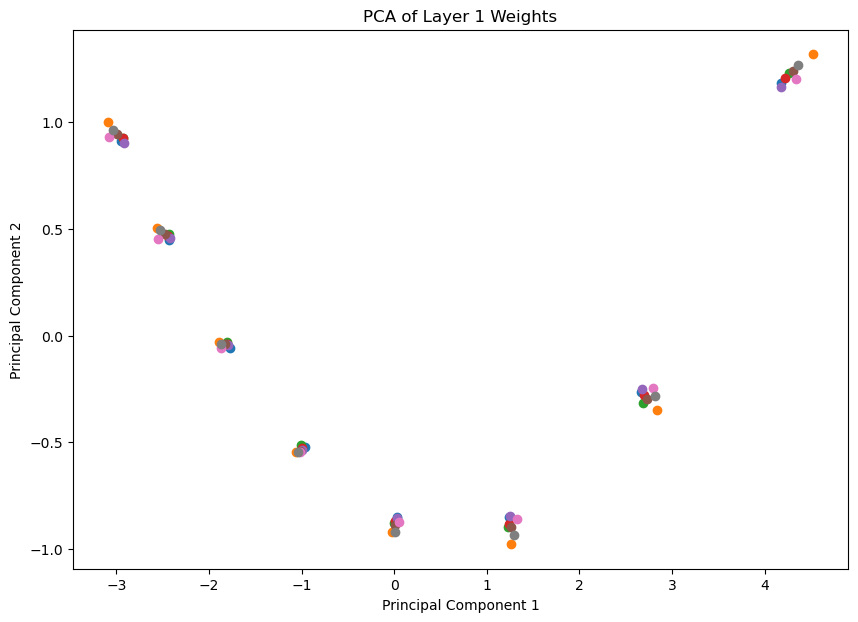

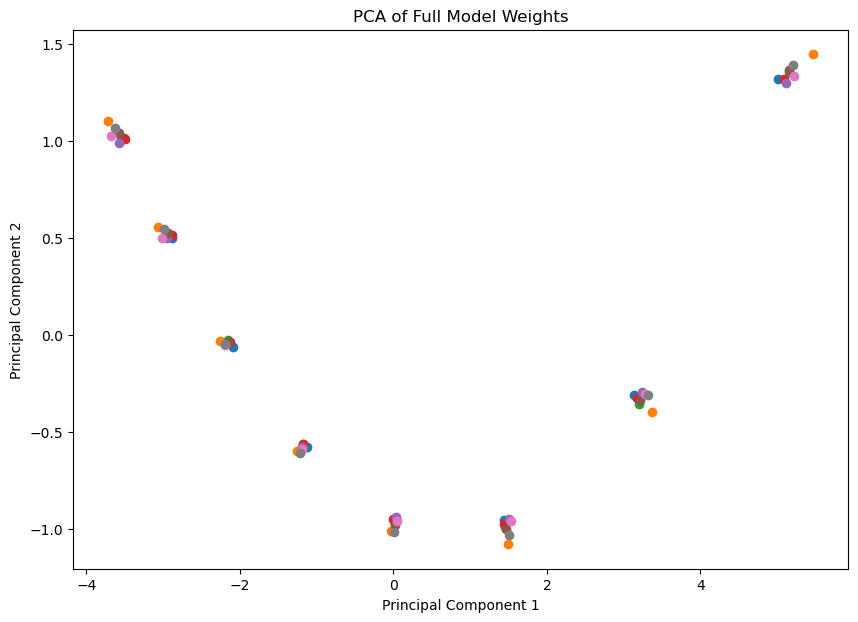

In [18]:
plot_pca_outcomes(layer1_pca_result, 'PCA of Layer 1 Weights')
plot_pca_outcomes(full_model_pca_result, 'PCA of Full Model Weights')

In [19]:
layer1_pca_result

[array([[ 4.1815605 ,  1.1844758 ],
        [ 2.6706028 , -0.26406172],
        [ 1.2380437 , -0.850216  ],
        [ 0.03003717, -0.850887  ],
        [-0.96512675, -0.52152705],
        [-1.7770085 , -0.05712776],
        [-2.4332006 ,  0.44692573],
        [-2.944909  ,  0.9124169 ]], dtype=float32),
 array([[ 4.5202    ,  1.3175173 ],
        [ 2.8369205 , -0.3483103 ],
        [ 1.2662082 , -0.97709405],
        [-0.01879863, -0.92171746],
        [-1.0611168 , -0.546423  ],
        [-1.8943992 , -0.03068859],
        [-2.562466  ,  0.5059583 ],
        [-3.0865455 ,  1.0007589 ]], dtype=float32),
 array([[ 4.2587256e+00,  1.2291863e+00],
        [ 2.6829281e+00, -3.1401360e-01],
        [ 1.2253655e+00, -8.9854932e-01],
        [-2.5840383e-03, -8.7556177e-01],
        [-1.0026543e+00, -5.1199472e-01],
        [-1.8050299e+00, -2.8261149e-02],
        [-2.4340765e+00,  4.7385350e-01],
        [-2.9226761e+00,  9.2534143e-01]], dtype=float32),
 array([[ 4.224561  ,  1.2057364 ],
 

In [20]:
full_model_pca_result

[array([[ 5.0129833 ,  1.3207897 ],
        [ 3.1290276 , -0.3106459 ],
        [ 1.4426429 , -0.9536745 ],
        [ 0.03089936, -0.94101423],
        [-1.1315693 , -0.5739717 ],
        [-2.0887895 , -0.05999672],
        [-2.8798091 ,  0.5021683 ],
        [-3.5153894 ,  1.0163455 ]], dtype=float32),
 array([[ 5.463471  ,  1.4458699 ],
        [ 3.3725512 , -0.39540043],
        [ 1.4951372 , -1.0768    ],
        [-0.02937702, -1.00955   ],
        [-1.2626128 , -0.5944996 ],
        [-2.257811  , -0.02804114],
        [-3.0651064 ,  0.5582758 ],
        [-3.7162495 ,  1.1001441 ]], dtype=float32),
 array([[ 5.1479735e+00,  1.3519894e+00],
        [ 3.1968389e+00, -3.5320398e-01],
        [ 1.4492223e+00, -9.8831344e-01],
        [ 3.1755993e-03, -9.5483834e-01],
        [-1.1773353e+00, -5.6187743e-01],
        [-2.1496334e+00, -2.6579194e-02],
        [-2.9229722e+00,  5.1759028e-01],
        [-3.5472689e+00,  1.0152332e+00]], dtype=float32),
 array([[ 5.0830398e+00,  1.3166970e+